In [11]:
import math
import gym
from gym import spaces, logger
from gym.utils import seeding
import numpy as np

import matplotlib.pyplot as plt
import torch
import seaborn as sns

#Now to implement q learning and variants on the above market environment
import sys
if "../../" not in sys.path:
  sys.path.append("../../") 

from TD.TD import GeneralQ #, ExperienceQ, DynaQ 
#from FA.model import TabularModel 
#from TD.Tabular import ExpTabAgent
#from lib.envs.market import Market

%matplotlib inline

In [12]:
class Market(gym.Env):
    def __init__(self, kappa, episodes, time_periods, mu, r, sigma, inv_range):

        self.episodes = episodes
        self.time_periods = time_periods
        self.epi = 0
        self.t = 0

        self.inv_range = inv_range

        self.mu = mu
        self.r = r
        self.sigma = sigma

        #self.S, self.B, self.dS, self.dB = self.generate_price_series()
        #self._number_of_states = int(np.max(self.S)*100)+1
        #print(self._number_of_states)

        #self._start_price = self.S[self.t,self.epi]
        self._start_wealth = 100.0
        #self.wealth = self._start_wealth
        self.kappa = kappa
        
        
        #self._startstate = (self._start_price, int(self._start_wealth/10))

        self.action_space = spaces.Discrete(len(inv_range))
        self.observation_space = spaces.Box(0,120, np.array([2]))
        
        self.seed()
        self.viewer = None
        self.state = None

        
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def reset(self):
        self.S, self.B, self.dS, self.dB = self.generate_price_series()
        #plt.plot(self.S)
        self.wealth = self._start_wealth
        self.state = (int(self.S[self.t,self.epi]*100),int(self._start_wealth/10))
        return np.array(self.state)
    
    def step(self, action):
        
        assert self.action_space.contains(action), "%r (%s) invalid"%(action, type(action))
        price_state, wealth_state = self.state
        
        #wealth = self.wealth
        prop = self.inv_range[action]

        discount = 0.99

        if self.t < self.time_periods:
            NB = (1-prop)*self.wealth/self.B[self.t]
            NS = prop*self.wealth/self.S[self.t, self.epi]

            dX = NB*self.dB[self.t] +NS*self.dS[self.t,self.epi]
            reward = dX - (self.kappa/2)*(dX**2)  
            self.wealth += dX

            done = False

            self.wealth_state = int(self.wealth/10)
            self.t += 1
            
            new_state = (int(self.S[self.t,self.epi]*100), self.wealth_state)
            self.state = new_state
            final_wealth = 0.0
            
            #print(self._state)
            #print(self.t)

        else:
            #reached the end of episode...needs tidying
            #print('done')
            self.t = 0
            self.epi = 0 #+=1

            reward = 0.0
            dX = 0.0
            final_wealth = self.wealth
            #self.wealth = 100.0
            done = True
            _ = self.reset()

        return np.array(self.state), reward, done, final_wealth

    def generate_price_series(self):
        I = 1 #self.episodes
        M = self.time_periods

        S0 = 1
        B0 = 1
        T = 1.0
        dt = T/M

        mu = self.mu
        r = self.r
        sigma = self.sigma

        S = np.zeros((M+1,I))
        dS = np.zeros((M,I))
        dB = np.zeros(M)

        B = np.zeros(M+1)
        B[0] = B0
        S[0] = S0

        for t in range(1, M+1):
            z = np.random.standard_normal(I)
            #df = 10
            #z = np.random.standard_t(df,I)
            S[t] = S[t-1]*np.exp((mu-0.5*sigma**2)*dt + sigma*math.sqrt(dt)*z)
            B[t] = B[t-1]*np.exp(r*dt)

        for t in range(1,M):
            dS[t] = S[t+1] - S[t]
            dB[t] = B[t+1] - B[t]

        return S, B, dS, dB

In [62]:
kappa = 0.003
episodes = 3000000
time_periods = 20
mu =0.10
rf = 0.02
sigma = 0.20

In [63]:
episodes = episodes #500k worked well? as did 1m

utes = 15
u_star = np.linspace(0,2, utes)

Mark = Market(kappa, episodes, time_periods, mu, rf, sigma, u_star) #parameters from earlier

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [64]:
def train_agent(kappa, episodes,):
    
    SARSA = False
    double = False
    utilities_mod = []
    rewards_mod = []
    wealth_episodes = []
    rsum = 0

    number_of_actions = 15 #again from earlier in the code  
    number_of_states = 120

    gamma = 0.95
    learning_rate = 0.10
    egreedy = 0.1
    wealth = 100.0

    start_state = int(wealth/10) 

    agent = GeneralQ(number_of_states, number_of_actions, start_state, SARSA, 
                 double, step_size=learning_rate) #here eps set to 0.1 anyway

    
    for i_episode in range(episodes-1):
        
        price_state, wealth_state = Mark.reset()
        state = wealth_state
        action = agent.behaviour_policy(agent._q[state])
        #print(state)

        while True:    

            (price_state, new_state) , reward, done, final_wealth = Mark.step(action) #(prop, wealth))
            action = agent.step(reward, gamma, new_state)
            rsum += reward
            state = new_state
            #print(state)

            if done:
                wealth_episodes.append(final_wealth)
                utilities_mod.append(np.log(final_wealth))
                rewards_mod.append(rsum)
                rsum = 0
                #wealth = 100.0
                break 

    q_name = 'gymtest'
    filename = q_name
    np.save(filename, agent.q_values)

    print(q_name + " last 50,000 rewards mean",np.mean(np.array(rewards_mod)[-50000:]))
    
    return agent.q_values, utilities_mod, rewards_mod, wealth_episodes

In [65]:
from lib.sim_prices import make_prices
from lib.execute_strat import execute_strat
from lib.graphs import make_baseline_graphs, make_agent_graphs, plot_sample_paths, plot_disc_utility, \
                        plot_mv_equiv, plot_const_step

In [66]:
episodes = 3000000
Q, utilities_mod, rewards_mod, wealth_episodes = train_agent(kappa, episodes)

gymtest last 50,000 rewards mean 9.115598479458546


In [67]:
wealth = 100.0

merton_ratio = (mu-rf)/sigma**2
best_action = np.argmin(np.abs(u_star-merton_ratio))
#temp change to execute strat
utilities_test_rand, rewards_test_rand, step_rew_rand, wealth_test_rand = execute_strat(kappa,mu, 
                                                                      rf, sigma, utes,u_star,best_action, 'Random', 
                                                                      time_periods=time_periods, wealth=wealth)
utilities_test_best, rewards_test_best, step_rew_best, wealth_test_best = execute_strat(kappa, mu, rf, sigma, 
                                                                      utes, u_star, best_action,'Merton', 
                                                                      time_periods=time_periods, wealth=wealth)

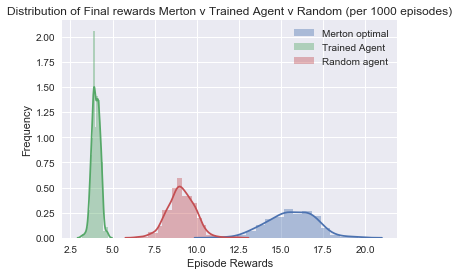

../../lib/graphs.py:134: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor('white')


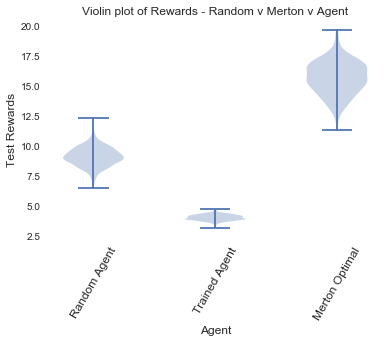

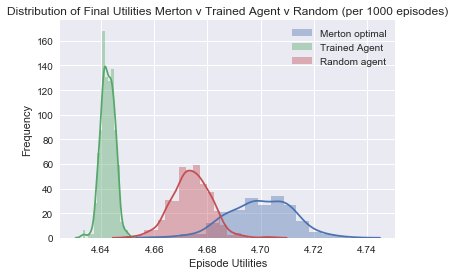

../../lib/graphs.py:154: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor('white')


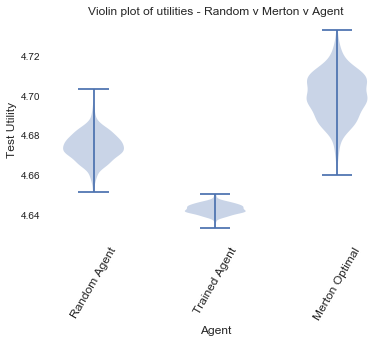

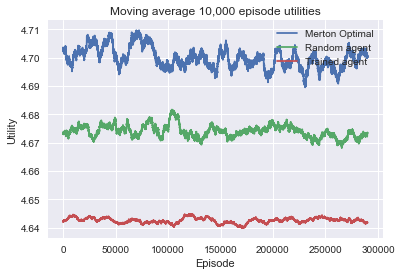

../../lib/graphs.py:173: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor('white')


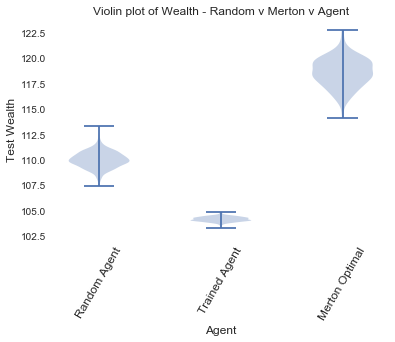

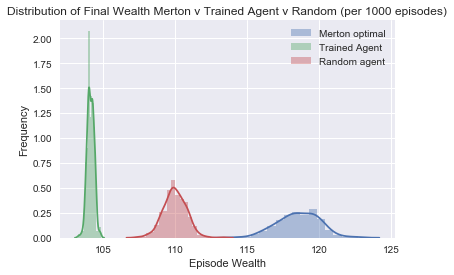

../../lib/graphs.py:193: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor('white')


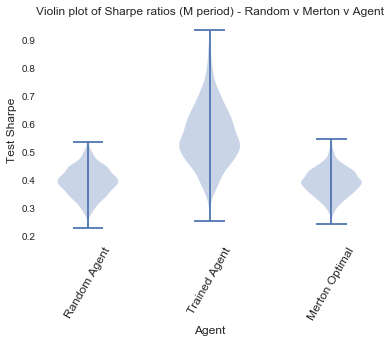

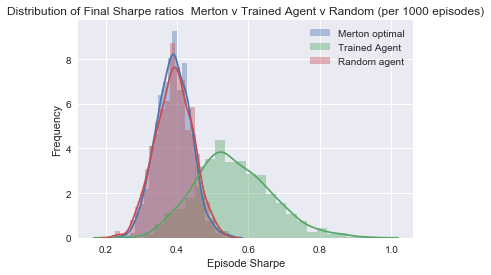

In [68]:
utilities_test, rewards_test, step_rew_test, wealth_test = execute_strat(kappa, mu, rf, sigma, utes, u_star,best_action, 
                                                            'Agent', q_values=Q, 
                                                            time_periods=time_periods, wealth=wealth)

results = make_agent_graphs(rewards_test_best, rewards_test_rand, rewards_test,
                  utilities_test_best, utilities_test_rand, utilities_test,
                         wealth_test_rand, wealth_test_best, wealth_test)

In [69]:
np.argmax(Q[0:60,:],1)

array([ 0,  0,  0,  0,  9,  8, 12,  4, 11,  7,  1,  3,  6,  2,  5,  7,  6,
       11,  3,  2, 12,  8,  8,  0,  0,  4,  0,  3,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0])

In [70]:
Q1 = np.load('../../TD/q_tables/models/Noisy2epi3000000er8kappa1.0.npy')

In [71]:
np.argmax(Q1[0:60,:],1)

array([ 0,  0,  0,  0,  0,  2,  8,  0,  6,  9, 10, 10,  8, 12, 11, 10, 13,
       12, 14,  7,  4,  9,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0])